In [1]:
# all import statements 

from functools import partial
from operator import methodcaller
import logging
logger = logging.getLogger()
logger.setLevel('DEBUG')
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter, ScalarFormatter
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
from concurrent import futures
from itertools import combinations, chain, permutations, product
import json
import networkx as nx
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist
from urllib.parse import urlparse
import datetime

# importing own modules
import comment_thread as ct
import author_network as an
import multi_comment_thread as mct

SBSTYLE = 'seaborn-talk'

In [2]:
# function to create DataFrame with all data for single project
def create_project_frame(project, titles, split):
    """Creates empty DataFrame with MultiIndex for index and columns
    Arguments: project-name, list of thread-titles, split(True/False)
    Return: DataFrame, list of indices for the threads"""
    indices = list(range(1, len(titles)+1))
    cols_0 = 5*['basic'] +\
                 10*['all threads'] +\
                 10*['research threads'] +\
                 10*['discussion threads']
    cols_1 = ['title', 'url', 'blog', 'research',  'thread'] +\
                3*['mthread (single)','mthread (accumulated)',
                'number of comments', 'number of comments (accumulated)',
                'network',
                'authors', 'number of authors', 'authors (accumulated)',
                'comment_counter', 'comment_counter (accumulated)']
    assert len(cols_0) == len(cols_1)
    if split:     
        cols = pd.MultiIndex.from_arrays([cols_0, cols_1])
    else:
        cols = pd.MultiIndex.from_arrays([cols_0[:15], cols_1[:15]])
    rows = pd.MultiIndex.from_tuples([(project, i) for i in indices],
                                               names=['Project', 'Ord'])
    return DataFrame(index=rows, columns=cols), indices

In [3]:
# function to add data to cols based on thread-types
def split_thread_types(pm_frame):
    """Fills the additional columns for research and discussion threads.
    Argument: DataFrame with intended columns.
    Return: DataFrame with additional data"""
    r_indices = pm_frame[pm_frame['basic', 'research']].index
    d_indices = pm_frame[~pm_frame['basic', 'research']].index
    r_threads = pm_frame[pm_frame['basic', 'research']]['basic', 'thread']
    d_threads = pm_frame[~pm_frame['basic', 'research']]['basic', 'thread']
    pm_frame['research threads', 'mthread (single)'] = pm_frame[pm_frame['basic', 'research']]['all threads', 'mthread (single)']
    pm_frame['research threads', 'mthread (accumulated)'] = Series([mct.MultiCommentThread(*r_threads[0:i+1]) for i in r_indices.droplevel()],
                                                 index=r_indices)
    pm_frame['research threads', 'network'] = pm_frame['research threads', 'mthread (accumulated)'].dropna().apply(an.AuthorNetwork)
    pm_frame['discussion threads', 'mthread (single)'] = pm_frame[~pm_frame['basic', 'research']]['all threads', 'mthread (single)']
    pm_frame['discussion threads', 'mthread (accumulated)'] = Series([mct.MultiCommentThread(*d_threads[0:i+1]) for i in d_indices.droplevel()],
                                                 index=d_indices)
    pm_frame['discussion threads', 'network'] = pm_frame['discussion threads', 'mthread (accumulated)'].dropna().apply(an.AuthorNetwork)
    return pm_frame

In [4]:
# function to add comment and author-data
def extend_project_frame(pm_frame):
    """Fills the columns with info about comments and authors.
    Argument: DataFrame with intended columns.
    Return: DataFrame with additional data"""
    for thread_type in ['all threads', 'research threads', 'discussion threads']:
        try:
            pm_frame[thread_type, 'number of comments'] = pm_frame[thread_type, 'mthread (single)'].dropna().apply(
                lambda x: len(x.node_name.keys()))
            pm_frame[thread_type, 'number of comments (accumulated)'] = pm_frame[thread_type, 'mthread (accumulated)'].dropna().apply(
                lambda x: len(x.node_name.keys()))
            pm_frame[thread_type, 'authors'] = pm_frame[thread_type, 'mthread (single)'].dropna().apply(
                lambda mthread: set(mthread.author_color.keys()))
            pm_frame[thread_type, 'number of authors'] = pm_frame[thread_type, 'authors'].dropna().apply(
                len)
            pm_frame[thread_type, 'authors (accumulated)'] = pm_frame[thread_type, 'mthread (accumulated)'].dropna().apply(
                lambda mthread: set(mthread.author_color.keys()))
            pm_frame[thread_type, 'comment_counter'] = pm_frame[thread_type, 'mthread (single)'].dropna().apply(
                lambda mthread: Counter(mthread.node_name.values()))
            pm_frame[thread_type, 'comment_counter (accumulated)'] = pm_frame[thread_type, 'mthread (accumulated)'].dropna().apply(
                lambda mthread: Counter(mthread.node_name.values()))
        except KeyError: # when split=False not all thread_types are in pm_frame
            pass
    return pm_frame

In [5]:
# function for forward-filling nan's where needed
def fill_project_frame(pm_frame):
    """forward-fills NaN-values for author/comment-related cols
    Argument: DataFrame with intended columns.
    Return: DataFrame with additional data"""
    for thread_type in ['research threads', 'discussion threads']:
        for data_type in ['number of comments (accumulated)', 'authors (accumulated)', 'comment_counter (accumulated)']:
            pm_frame[thread_type, data_type] = pm_frame[thread_type, data_type].fillna(method='ffill')
    return pm_frame

In [6]:
# function to process a single polymath-project (relies on above functions)
def process_polymath(project, split=False):
    """Created DataFrame for a given project
    Argument: Project-title.
    Return: DataFrame with additional data"""
    titles, threads = list(zip(*ct.main(
                project.replace("Polymath", "pm"),
                use_cached=False, cache_it=False, merge=False).items()))
    pm_frame, indices = create_project_frame(project, titles, split)
    pm_frame['basic', 'title'] = titles
    pm_frame['basic', 'thread'] = threads
    pm_frame['basic', 'url'] = [thread.data.url for thread in threads]
    pm_frame['basic', 'research'] = [thread.data.is_research for thread in threads]
    pm_frame['basic', 'blog'] = [thread.data.thread_url.netloc.split('.')[0].title() for thread in threads]

    pm_frame['all threads','mthread (single)'] = [mct.MultiCommentThread(thread) for thread in threads]
    pm_frame['all threads','mthread (accumulated)'] = [mct.MultiCommentThread(*threads[0:i+1]) for i in indices]
    pm_frame['all threads','network'] = pm_frame['all threads', 'mthread (accumulated)'].apply(an.AuthorNetwork)
    if split:
        pm_frame = split_thread_types(pm_frame)
    pm_frame = pm_frame.pipe(
        extend_project_frame).pipe(
        fill_project_frame)
    return pm_frame

In [7]:
# creating the DataFrames for all projects
start = datetime.datetime.now()
print("starting at: ", start)
PM1_FRAME = process_polymath("Polymath 1", split=True)
stop = datetime.datetime.now()
print("Polymath 1 processed in ", stop-start)
start = datetime.datetime.now()
PM2_FRAME = process_polymath("Polymath 2", split=True)
stop = datetime.datetime.now()
print("Polymath 2 processed in ", stop-start)
start = datetime.datetime.now()
PM3_FRAME = process_polymath("Polymath 3", split=True)
stop = datetime.datetime.now()
print("Polymath 3 processed in ", stop-start)
start = datetime.datetime.now()
PM4_FRAME = process_polymath("Polymath 4", split=True)
stop = datetime.datetime.now()
print("Polymath 4 processed in ", stop-start)
start = datetime.datetime.now()
PM5_FRAME = process_polymath("Polymath 5", split=True)
stop = datetime.datetime.now()
print("Polymath 5 processed in ", stop-start)
start = datetime.datetime.now()
PM6_FRAME = process_polymath("Polymath 6", split=True)
stop = datetime.datetime.now()
print("Polymath 6 processed in ", stop-start)
start = datetime.datetime.now()
PM7_FRAME = process_polymath("Polymath 7", split=True)
stop = datetime.datetime.now()
print("Polymath 7 processed in ", stop-start)
start = datetime.datetime.now()
PM8_FRAME = process_polymath("Polymath 8", split=True)
stop = datetime.datetime.now()
print("Polymath 8 processed in ", stop-start)
start = datetime.datetime.now()
PM9_FRAME = process_polymath("Polymath 9", split=True)
stop = datetime.datetime.now()
print("Polymath 9 processed in ", stop-start)
start = datetime.datetime.now()
PM10_FRAME = process_polymath("Polymath 10", split=True)
stop = datetime.datetime.now()
print("Polymath 10 processed in ", stop-start)
start = datetime.datetime.now()
PM11_FRAME = process_polymath("Polymath 11", split=True)
stop = datetime.datetime.now()
print("Polymath 11 processed in ", stop-start)
print("completed at: ", datetime.datetime.now())

starting at:  2016-11-19 13:37:54.460551
Polymath 1 processed in  0:01:15.452219
Polymath 2 processed in  0:00:00.968483


Polymath 3 processed in  0:00:21.858532
Polymath 4 processed in  0:00:15.613896


Polymath 5 processed in  0:02:43.707455
Polymath 6 processed in  0:00:02.983254


Polymath 7 processed in  0:00:17.413186


Polymath 8 processed in  0:05:18.977937
Polymath 9 processed in  0:00:13.389964


['Polymath10: The Erdos Rado Delta System\xa0Conjecture', 'Polymath10, Post 2: Homological\xa0Approach', 'Polymath 10 Post 3: How are we\xa0doing?', 'Polymath10-post 4: Back to the drawing\xa0board?', 'Polymath 10 Emergency Post 5: The Erdos-Szemeredi Sunflower Conjecture is Now\xa0Proven.', 'Polymath 10 post 6: The Erdos-Rado sunflower conjecture,  and the Turan (4,3) problem: homological\xa0approaches.']
['Polymath10: The Erdos Rado Delta System\xa0Conjecture', 'Polymath10, Post 2: Homological\xa0Approach', 'Polymath 10 Post 3: How are we\xa0doing?', 'Polymath10-post 4: Back to the drawing board?', 'Polymath 10 Emergency Post 5: The Erdos-Szemeredi Sunflower Conjecture is Now Proven', 'Polymath 10 post 6: The Erdos-Rado sunflower conjecture, and the Turan (4,3) problem: homological approaches']
Polymath 10 processed in  0:00:27.032609


['Frankl’s union-closed conjecture — a possible Polymath\xa0project?', 'FUNC1 — strengthenings, variants, potential\xa0counterexamples', 'FUNC2 — more\xa0examples', 'FUNC3 — further strengthenings and\xa0variants', 'FUNC4 — further\xa0variants']
['Frankl’s union-closed conjecture — a possible Polymath project?', 'FUNC1 — strengthenings, variants, potential counterexamples', 'FUNC2 — more examples', 'FUNC3 — further strengthenings and variants', 'FUNC4 — further variants']
Polymath 11 processed in  0:00:25.479969
completed at:  2016-11-19 13:49:17.339740


In [8]:
# merging all DataFrames in a single frame
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME, PM9_FRAME, PM10_FRAME, PM11_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]

In [9]:
# set of all authors as global variable
ALL_AUTHORS = set.union(*PM_FRAME['all threads', 'authors'].tolist())

In [10]:
# utility-functions to get specific parts of PM_FRAME
def get_last(thread_type):
    """thread_type is either 'all threads', 'research threads', or 'discussion threads'
    Returns tuple of:
    (1) DataFrame with only last row for each project
    (2) List of positions for last rows DataFrame"""
    source = PM_FRAME[['basic', thread_type]].dropna() if thread_type else PM_FRAME
    projects = source.index.droplevel(1).unique()
    ords = [source.loc[project].index[-1] for project in projects]
    lasts_index = pd.MultiIndex.from_tuples(list(zip(projects, ords)),names=['Project', 'Ord'])
    data = source.loc[lasts_index]
    return data, lasts_index

def get_last2(df, thread_type):
    source = PM_FRAME[['basic', thread_type]].dropna() if thread_type else PM_FRAME
    idx = pd.IndexSlice
    data = source.idx[:,-1]
    return data

def get_project_at(project, thread_type, stage):
    if stage == -1:
        logging.info("Stage is last non-null stage of %s", project)
        out = PM_FRAME.loc[project][thread_type].dropna().iloc[stage]
    else:
        out = PM_FRAME.loc[project][thread_type].iloc[stage]
        nulls = pd.isnull(out)
        if np.any(nulls):
            logging.warning("Some empty values: %s", out.index[nulls])
    return out

In [11]:
# wrappers for mthread-methods
def plot_activity_author(project,
                         thread_type="all threads", stage=-1,
                         intervals=1):
    """Wrapper function for mthread.plot_activity_author
    Plots author activity over time for project (limited to thread_type)"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.plot_activity_author(project=project,
                              intervals=intervals)

def plot_activity_thread(project,
                         thread_type="all threads", stage=-1,
                         color_by="cluster",
                         intervals=1):
    """Wrapper function for mthread.plot_activity_thread
    Plots thread activity over time for project (limited to thraead_type).
    color_by is either cluster or author"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.plot_activity_thread(project=project,
                              color_by=color_by,
                              intervals=intervals)

def plot_discussion_tree(project, thread_type="all threads", intervals=10, stage=-1):
    """Wrapper function for mthread.draw_graph
    Plots structure of discussion in project"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.draw_graph(project=project,
                    intervals=intervals)

# could be extended to single mthreads to look at growth of single threads
def plot_growth(project,
                thread_type="all threads", stage=-1):
    """Wrapper function for mthread.plot_growth
    Plots growth in comments in discussion"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.plot_growth(project=project)

In [12]:
# wrapper-functions for author_network plotting-methods
def plot_activity_pie(project,
                      thread_type="all threads", stage=-1,
                      what='total comments'):
    """Wrapper function for author_network.plot_author_activity_pie
    Plots pie-chart of comment_activity of commenters is project.
    'what' can be 'total comments', or 'word counts'"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_author_activity_pie(project=project,
                                  what=what)
    
def plot_activity_bar(project,
                      thread_type="all threads", stage=-1,
                      what="by level",
                      fontsize=6):
    """Wrapper function for author_network.plot_activity_bar
    Plots bar-chart of comment_activity of commenters in project
    'what' can be 'by level' or 'word counts'"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_author_activity_bar(project=project,
                                  what=what,
                                  fontsize=fontsize)

def plot_activity_prop(project,
                       thread_type="all threads", stage=-1,
                       fontsize=6):
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_activity_prop(project=project)

def plot_activity_degree(project,
                         thread_type="all threads", stage=-1,
                         graph_type='interaction',
                         measures=None,
                         delete_on=None, thresh=0,
                         fontsize=6):
    """Wrapper function for author_network.plit_activity_degree
    Plots superposition of bar-chart of comment-activity and line-chart of degree-centrality"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_activity_degree(project=project,
                              g_type=graph_type,
                              measures=measures,
                              delete_on=delete_on, thresh=thresh,
                              fontsize=fontsize)

def plot_centrality_measures(project,
                         thread_type="all threads", stage=-1,
                         graph_type='interaction',
                         measures=None,
                         delete_on=None, thresh=0,
                         fontsize=6):
    """Wrapper function for author_network.plot_activity_degree
    Plots superposition of bar-chart of comment-activity and line-chart of degree-centrality"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_centrality_measures(project=project,
                              g_type=graph_type,
                              measures=measures,
                              delete_on=delete_on, thresh=thresh,
                              fontsize=fontsize)

def plot_comment_histogram(project,
                          thread_type="all threads", stage=-1,
                          what="total comments", bins=10,
                          fontsize=6):
    """Wrapper function for author_network.plot_author_activity_hist.
    'what' is either 'total comments' or 'word counts'"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_author_activity_hist(project=project,
                                   what=what, bins=bins,
                                   fontsize=fontsize)

def thread_or_project(project, thread_type, stage, thread):
    """Helper function to create data from project or single thread."""
    if thread is None:
        data = get_project_at(project, thread_type, stage)['network']
    else:
        print("Overriding thread_type and stage")
        mthread = get_project_at(project, "all threads", thread)['mthread (single)']
        thread_title = get_project_at(project, "basic", thread)['title']
        data = an.AuthorNetwork(mthread)
        project = "{}\n{}".format(project, thread_title)
    return project, data
 
def plot_interaction_trajectories(project,
                                  thread_type="all threads", stage=-1,
                                  thread=None,
                                  loops=False,
                                  thresh=None, select=None,
                                  l_thresh=5):
    """Wrapper function for author_network.plot_i_trajectories.
    If thread is not None, an author_network is created for a single thread at iloc[thread]"""
    project, data = thread_or_project(project, thread_type, stage, thread)
    data.plot_i_trajectories(project=project,
                            loops=loops, thresh=thresh, select=select,
                            l_thresh=l_thresh)

def plot_distance_from_centre(project,
                             thread_type="all threads", stage=-1,
                             thread=None,
                             thresh=2,
                             show_threads=True):
    """Wrapper function for author_network.plot_centre_dist.
    If thread is not None, an author_network is created for single thread at iloc[thread]"""
    project, data = thread_or_project(project, thread_type, stage, thread)
    data.plot_centre_dist(thresh=thresh, show_threads=show_threads)

def plot_scatter_authors(project,
                         thread_type="all threads", stage=-1,
                         thread=None,
                         measure="betweenness centrality",
                         thresh=15):
    """Wrapper function for author_network.scatter_authors.
    If thread is not None, an author_network is created for signle thread at iloc[thread]"""
    project, data = thread_or_project(project, thread_type, stage, thread)
    data.scatter_authors(measure=measure, project=project, thresh=thresh)

In [13]:
# wrapper function for correlation between network-measures in author_network
def measures_corr(project, graph_type, thread_type="all threads", stage=-1):
    data = get_project_at(project, thread_type, stage)['network']
    return data.corr_centrality_measures(project=project, g_type=graph_type)

In [14]:
# wrappers for network-drawing methods of author_network
def draw_network(project, graph_type, thread_type="all threads", reset=False, stage=-1):
    """Wrapper function for author_network.draw_graph.
    Plots the interaction-network between the commenters in project."""
    get_project_at(project, thread_type, stage)['network'].draw_graph(project=project, graph_type=graph_type, reset=reset)
    
def draw_centre(project, thread_type="all threads", stage=-1, show=False, skips=10, zoom=1):
    """Wrapper function for author_network.draw_centre_discussion"""
    get_project_at(project, thread_type, stage)['network'].draw_centre_discussion(show=show, skips=skips, zoom=zoom)

In [15]:
# area-plots for evolution of participants across projects (can be limited to thread-types)
def plot_community_evolution(project, thread_type):
    """thread_type is 'all threads', 'research threads', or 'discussion threads'"""
    if not thread_type:
        logging.warning("Need explicit thread type")
        return
    try:
        int(project.split()[-1])
        as_threads = True
    except ValueError:
        as_threads = False
    if as_threads:
        data = PM_FRAME[['basic', thread_type]].loc[project].dropna()
        added = (data[thread_type, 'authors'] - data[thread_type, 'authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data[thread_type, 'authors'].shift(1) - data[thread_type, 'authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data[thread_type, 'authors'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"], index=data.index)
        df.index = range(len(df))
        try:
            assert np.all(df == df.dropna())
        except AssertionError:
            logging.warning("Some nan-values still present")
        df.index.name = "Threads"
    else:
        data, positions = get_last(thread_type)
        added = (data[thread_type, 'authors (accumulated)'] - data[thread_type, 'authors (accumulated)'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data[thread_type, 'authors (accumulated)'].shift(1) - data[thread_type, 'authors (accumulated)']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data[thread_type, 'authors (accumulated)'].dropna().apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"])
        df.index = list(range(1, len(positions) + 1))
    matplotlib.style.use(SBSTYLE)
    axes = df.plot(kind="area", title="Community Evolution in {} ({})".format(project, thread_type),
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes.set_xticks(df.index)
    axes.xaxis.set_ticks_position('bottom')
    axes.yaxis.set_ticks_position('left')
    if as_threads:
        axes.set_xticklabels(data['basic', 'title'], rotation=90, fontsize='small')
    else:
        xlabels = data.index.droplevel(1)
        axes.set_xticklabels(xlabels, rotation=90, fontsize='small')
    axes.set_ylabel('number of active commenters')

In [16]:
# helper-functions for heat-maps
def project_participation_evolution(n=2, skip_anon=True, research_only=False):
    if not research_only:
        thread_type = 'all threads'
        data, _ = get_last(thread_type)
        all_authors = list(ALL_AUTHORS)
        title = "Participation per project in Polymath (threshold = {})".format(n)
    else:
        thread_type = 'research threads'
        data, _ =  get_last(thread_type)
        all_authors = set().union(*data['research threads', 'authors (accumulated)'])
        title = "Participation per project in Polymath (threshold = {}, only research-threads)".format(n)
    data.index = data.index.droplevel(1)
    author_project = DataFrame(columns=all_authors)
    for author in author_project.columns:
        author_project[author] = data[thread_type, 'authors (accumulated)'].apply(lambda project: author in project)
    author_project = author_project.T
    author_project = author_project.sort_values(by=data.index.tolist(), ascending=False)
    author_project = author_project.drop("Anonymous") if skip_anon else author_project
    select = author_project.sum(axis=1) >= n
    return author_project, data.index, select, title

def thread_participation_evolution(project, n=2, skip_anon=True, research_only=False):
    if not research_only:
        thread_type = 'all threads'
        title = "Participation per thread in {} (threshold = {})".format(project, n)
    else:
        thread_type = 'research threads'        
        title = "Participation per thread in {} (threshold = {}, only research-threads)".format(project, n)
    data = PM_FRAME.loc[project][['basic', thread_type]]
    data = data.dropna()
    all_authors = set().union(*data[thread_type, 'authors'])
    author_thread = DataFrame(columns=all_authors)
    for author in author_thread.columns:
        author_thread[author] = data[thread_type, 'authors'].apply(lambda thread: author in thread)
    author_thread = author_thread.T
    author_thread = author_thread.sort_values(by=data.index.tolist(), ascending=False)
    author_thread = author_thread.drop("Anonymous") if skip_anon else author_thread
    author_thread.columns.name = "Threads"
    select = author_thread.sum(axis=1) >= n
    return author_thread, data.index, select, title

def plot_participation_evolution(author_project, indices, select, title, fontsize=6):
    matplotlib.style.use(SBSTYLE)
    factor = 30 - len(indices) if len(indices) <= 30 else 40 - len(indices)
    colors = [plt.cm.Set1(factor*i) for i in range(len(indices))]
    axes = author_project.loc[select].plot(kind="bar", stacked=True, color=colors,
                                    title=title, fontsize=fontsize)
    axes.yaxis.set_ticks_position('left')
    axes.xaxis.set_ticks_position('bottom')

In [17]:
def general_heatmap(authors=None, binary=False, thread_type='all threads', thread_level=True,
                    binary_method='average', method='ward', scale_data=False):
    if thread_level:
        authors_filtered = list(ALL_AUTHORS)
        try:
            authors_filtered.remove("Anonymous")
        except:
            pass
        data=PM_FRAME[thread_type, 'comment_counter']
    else:
        authors_filtered = list(ALL_AUTHORS) if not authors else authors 
        try:
            authors_filtered.remove("Anonymous")
        except:
            pass
        data = get_last(thread_type)[0][thread_type, 'comment_counter (accumulated)']
    if binary:
        as_matrix=np.array([[True if author in data[thread] else False for author in authors_filtered]
                        for thread in data.index])
        Z_author = linkage(as_matrix.T, method=binary_method, metric='hamming')
        Z_thread = linkage(as_matrix, method=binary_method, metric='hamming')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        #print("Cophenetic Correlation Coefficient with {}: {}".format(binary_method, c))
    else:
        as_matrix = []
        for thread in data.index:
            new_row = [data.loc[thread][author] for author in authors_filtered]
            as_matrix.append(new_row)
        # check if axis for normalize should be 1 (normalize each sample) or 0 (normalize each feature)
        # normalizing each feature makes sense, but keep in mind that list of authors was filtered!
        # should project-sizes really matter or not?
        as_matrix = np.array(as_matrix)
        if scale_data:
            as_matrix = as_matrix / as_matrix.sum(axis=1).reshape(-1,1) * 100
        Z_author = linkage(as_matrix.T, method=method, metric='euclidean')
        Z_thread = linkage(as_matrix, method=method, metric='euclidean')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        #print("Cophenetic Correlation Coefficient with {}: {}".format(method, c))
    # compute dendogram and organise DataFrame
    ddata_author = dendrogram(Z_author, color_threshold=20,
                              no_plot=True)
    ddata_thread = dendrogram(Z_thread, color_threshold=.07, no_plot=True)
    df = DataFrame(as_matrix, columns=authors_filtered)
    cols = [authors_filtered[i] for i in ddata_author['leaves']]
    df = df[cols]
    rows = [df.index[i] for i in ddata_thread['leaves']]
    df = df.reindex(rows)
    title = "Project-Engagement in Polymath ({})".format(thread_type)
    return df, binary, title

def plot_heatmap(df, binary, title, log=True, fontsize=8):
    # start setting up plots
    matplotlib.style.use(SBSTYLE)
    fig, ax_heatmap = plt.subplots()
    # plot heatmap
    heatmap = ax_heatmap.pcolor(df,
                        edgecolors='w',
                        cmap=mpl.cm.binary if binary else mpl.cm.viridis_r,
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax_heatmap.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax_heatmap.set_aspect('equal')  # ensure heatmap cells are square
    ax_heatmap.xaxis.set_ticks_position('bottom')  # put column labels at the bottom
    ax_heatmap.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    ax_heatmap.set_title(title)
    
    ax_heatmap.set_yticks(np.arange(0.5, len(df.index)+.5, 1))
    ax_heatmap.set_yticklabels(df.index + 1, fontsize=fontsize)
    ax_heatmap.set_xticks(np.arange(len(df.columns)) + 0.5)
    ax_heatmap.set_xticklabels(df.columns, rotation=90, fontsize=fontsize)
    
    if not binary:
        divider_h = make_axes_locatable(ax_heatmap)
        cax = divider_h.append_axes("right", "3%", pad="1%")
        plt.colorbar(heatmap, cax=cax)
        cax.yaxis.set_major_formatter(
            FuncFormatter(
                lambda y,pos: ('{:.1f}'.format(y))))

    lines = (ax_heatmap.xaxis.get_ticklines() +
             ax_heatmap.yaxis.get_ticklines())
    plt.setp(lines, visible=False)
    
    plt.tight_layout()

In [18]:
def project_heatmap(project, binary=False, thread_type='all threads', cluster_threads = True,
                    method='ward', binary_method='average',
                    scale_data=True,
                    skip_anon=True, log=False, fontsize=8):
    """
    Plots clustered heatmaps of thread-participation per author.
    Based on: https://gist.github.com/s-boardman/cef9675329a951e89e93
              https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    """
    data = PM_FRAME[thread_type].loc[project].copy()
    all_authors = sorted(list(data.iloc[-1]['authors (accumulated)']))
    if skip_anon:
        try:
            all_authors.remove("Anonymous")
        except ValueError:
            pass
    data = data['comment_counter']
    title = "Participation per thread in " + project
    if binary:
        as_matrix=np.array([[True if author in data[thread] else False for author in all_authors]
                        for thread in data.index])
        Z_author = linkage(as_matrix.T, method=binary_method, metric='hamming')
        if cluster_threads:
            Z_thread = linkage(as_matrix, method=binary_method, metric='hamming')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        print("Cophenetic Correlation Coefficient with {}: {}".format(binary_method, c))
    else:
        as_matrix = []
        for thread in data.index:
            new_row = [data.loc[thread][author] for author in all_authors]
            as_matrix.append(new_row)
        as_matrix = np.array(as_matrix)
        if scale_data:
            as_matrix = as_matrix / as_matrix.sum(axis=1).reshape(-1,1) * 100
        Z_author = linkage(as_matrix.T, method=method, metric='euclidean')
        if cluster_threads:
            Z_thread = linkage(as_matrix, method=method, metric='euclidean')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        #print("Cophenetic Correlation Coefficient with {}: {}".format(method, c))
    ddata_author = dendrogram(Z_author, color_threshold=.07, no_plot=True)
    df = DataFrame(as_matrix, columns=all_authors)
    cols = [all_authors[i] for i in ddata_author['leaves']]
    df = df[cols]
    if cluster_threads:
        ddata_thread = dendrogram(Z_thread, color_threshold=.07, no_plot=True)
        rows = [df.index[i] for i in ddata_thread['leaves']]
        df = df.reindex(rows)
    matplotlib.style.use('seaborn-poster')
    fig, ax = plt.subplots(1,1)
    heatmap = ax.pcolor(df,
                        edgecolors='k' if binary else 'w',
                        cmap=mpl.cm.binary if binary else mpl.cm.viridis_r,
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax.set_aspect('equal')  # ensure heatmap cells are square
    ax.xaxis.set_ticks_position('bottom')  # put column labels at the bottom
    ax.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    ax.set_title("Thread-participation in {}".format(project))
    
    plt.yticks(np.arange(len(df.index)) + 0.5, df.index, fontsize=fontsize)
    plt.xticks(np.arange(len(df.columns)) + 0.5, df.columns, rotation=90, fontsize=fontsize)
    
    if not binary:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", "3%", pad="1%")
        plt.colorbar(heatmap, cax=cax)
        cax.yaxis.set_major_formatter(
            FuncFormatter(
                lambda y,pos: ('{:.1f}'.format(y))))
    
    plt.tight_layout()

In [19]:
# double plot of commenting and participants in a single project
def plot_thread_evolution(project, compress=1, sel=[], sharex=True):
    # data for evolution
    thread_type='all threads'
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    added = (data[thread_type, 'authors'] - data[thread_type, 'authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
    removed = (data[thread_type, 'authors'].shift(1) - data[thread_type, 'authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
    size = data[thread_type, 'number of authors'] - added
    df1 = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                   columns=["joined", "current", "left"], index=data.index)
    df1.index.name = ""
    # data for engagement
    engagement = {}
    for thread_type in ['all threads', 'research threads', 'discussion threads']:
        engagement[thread_type] = data[thread_type, 'number of authors'] / data[thread_type, 'number of comments']
    df2 = DataFrame(engagement, index=data.index)
    sizes = (data['all threads', 'number of comments'] / compress).tolist()
    df2.index.name = ""
    df2_max=df2['all threads'].max()
    all_mean=df2['all threads'].mean()
    res_mean=df2['research threads'].mean()
    disc_mean=df2['discussion threads'].mean()
    # setting up plot
    matplotlib.style.use('seaborn-talk')
    fig, axes = plt.subplots(2, 1, figsize=(15, 6), squeeze=False, sharex=sharex)
    plt.subplots_adjust(hspace=0.2)
    # plot bottom
    df1.plot(kind="area", ax = axes[1][0], title="",
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes[1][0].set_ylabel('active commenters')
    axes[1][0].legend(bbox_to_anchor=(1.14, 1))
    # plot top
    df2[['research threads', 'discussion threads']].plot(kind='bar', ax = axes[0][0], color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes[0][0].set_ylabel('comments per participant')
    axes[0][0].set_yticklabels([round(1/i, 2) for i in axes[0][0].get_yticks()])
    axes[0][0].yaxis.get_major_ticks()[0].label1.set_visible(False)
    axes[0][0].get_xaxis().set_ticks([])
    axes[0][0].set_xlabel("")
    xlims = (0.5,len(df1.index)+.5)
    axes[0][0].set_xlim(xlims)
    axes[0][0].set_ylim(0, df2_max*1.1)
    axes[0][0].legend(bbox_to_anchor=(1.23, 1))
    axes[0][0].lines.append(
        mpl.lines.Line2D(list(xlims), [all_mean, all_mean], linestyle = '--', linewidth = .5, color = 'Blue', zorder = 1, transform = axes[0][0].transData))
    axes[0][0].lines.append(
        mpl.lines.Line2D(list(xlims), [res_mean, res_mean], linestyle = '-', linewidth = .5, color = 'lightsteelblue', zorder = 1, transform = axes[0][0].transData))
    axes[0][0].lines.append(
        mpl.lines.Line2D(list(xlims), [disc_mean, disc_mean], linestyle = '-', linewidth = .5, color = 'steelblue', zorder = 1, transform = axes[0][0].transData))
    for container in axes[0][0].containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df2.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    all_threads = data['all threads'][['number of comments', 'number of authors']]
    for i in list(set(sel).intersection(data.index)):
            axes[0][0].text(
                i + .25,
                df2.loc[i, 'all threads']+.01,
                "{} comments\n {} commenters".format(
                    all_threads.loc[i,'number of comments'],
                    all_threads.loc[i, 'number of authors']),
                ha="center", va="bottom", fontsize='small')

# Modelling Online Collaborative Mathematics
### Patrick Allo
#### Oxford Internet Institute

# The Polymath Projects
### *I’m interested in the question of whether it is possible for lots of people to solve one single problem rather than lots of people to solve one problem each*
#### Timothy Gowers “Is massively collaborative mathematics possible?”


It seems to me that, at least in theory, a different model could work: different, that is, from the usual model of people working in isolation or collaborating with one or two others. Suppose one had a forum (in the non-technical sense, but quite possibly in the technical sense as well) for the online discussion of a particular problem. The idea would be that anybody who had anything whatsoever to say about the problem could chip in. And the ethos of the forum -- in whatever form it took -- would be that **comments would mostly be kept short.** In other words, **what you would not tend to do, at least if you wanted to keep within the spirit of things, is spend a month thinking hard about the problem and then come back and write ten pages about it**. Rather, you would contribute ideas even if they were undeveloped and/or likely to be wrong.

Here is where the beauty of blogs, wikis, forums etc. comes in: they are completely public, as is their entire history. To see what effect this might have, imagine that a problem was being solved via comments on a blog post. Suppose that the blog was pretty active and that the post was getting several interesting comments. And suppose that you had an idea that you thought might be a good one. Instead of the usual reaction of being afraid to share it in case someone else beat you to the solution, you would be afraid not to share it in case someone beat you to that particular idea. **And if the problem eventually got solved, and published under some pseudonym like Polymath, say, with a footnote linking to the blog and explaining how the problem had been solved, then anybody could go to the blog and look at all the comments. And there they would find your idea and would know precisely what you had contributed.** There might be arguments about which ideas had proved to be most important to the solution, but at least all the evidence would be there for everybody to look at.

# Why Polymath, again?

### We know more now

+ More projects too investigate
+ We understand the broader context of science online better

### But also plenty we do not yet know
+ Is it really a different kind of mathematics?
+ How valuable is this for the philosophy of mathematical practices?
+ What's special about the social epistemology of mathematics?
+ How does it actually work?

## Disciplinary perspective
+ **Scientific practices:** e-science, crowd-science & citizen science *vs* mathematical practices
+ **Social-informational patterns:** Between social networks and logics of information and collaboration.

In [20]:
# assembling data for overview
THE_DATA, _ = get_last(None)
THE_DATA.index= THE_DATA.index.droplevel(1)
THE_DATA.columns = THE_DATA.columns.swaplevel()
AUTHOR_DATA = THE_DATA['authors (accumulated)'].copy()
COMMENT_DATA = THE_DATA['number of comments (accumulated)', 'all threads'].copy()
AUTHOR_DATA['authors only active in research threads'] = AUTHOR_DATA['research threads'] - AUTHOR_DATA['discussion threads']
AUTHOR_DATA['authors only active in "discussion" threads'] = AUTHOR_DATA['discussion threads'] - AUTHOR_DATA['research threads']
AUTHOR_DATA['authors active in both types of threads'] = AUTHOR_DATA['all threads'] - AUTHOR_DATA['authors only active in research threads'] - AUTHOR_DATA['authors only active in "discussion" threads']
for project in AUTHOR_DATA.index:
    if pd.isnull(AUTHOR_DATA.loc[project]['authors only active in research threads']):
        AUTHOR_DATA.loc[project]['authors only active in research threads'] = AUTHOR_DATA.loc[project]['all threads']
AUTHOR_DATA = AUTHOR_DATA[['authors only active in research threads', 'authors active in both types of threads', 'authors only active in "discussion" threads']]
AUTHOR_DATA = AUTHOR_DATA.applymap(lambda set: len(set) if pd.notnull(set) else 0)

# The projects

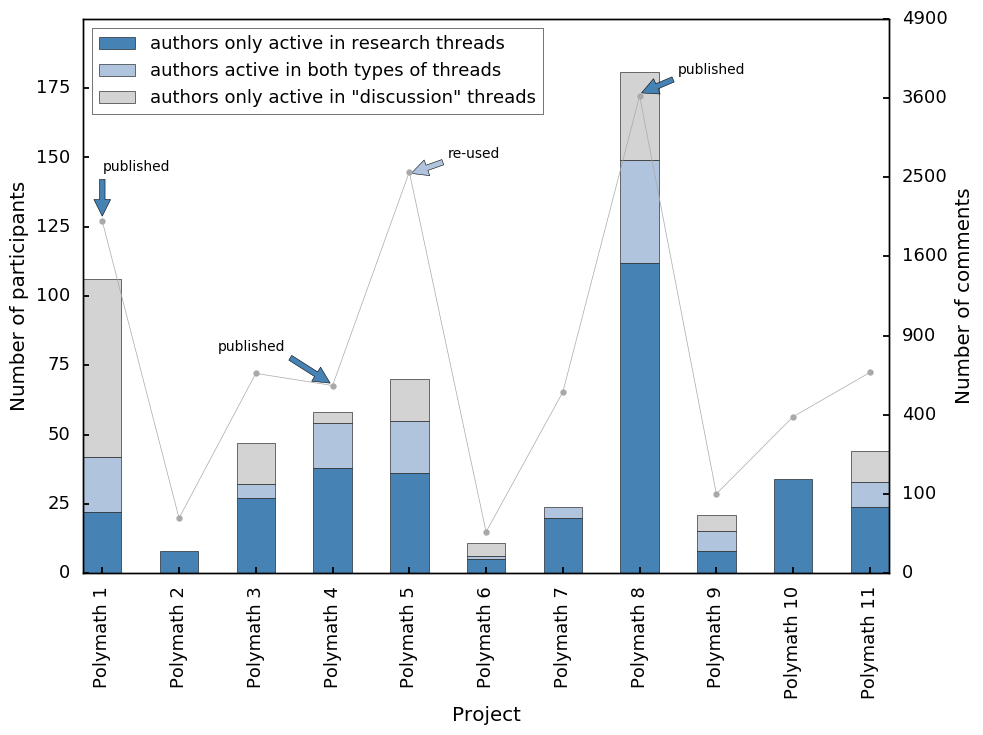

In [21]:
# create overview-plot for all projects
matplotlib.style.use(SBSTYLE)
axes = plt.subplot()
AUTHOR_DATA.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'], ax=axes)
#,title="Overview of all projects")
axes.xaxis.set_ticks_position('bottom')
axes.set_ylabel("Number of participants")
axes.set_ylim(0,200)
axes.set_yticks(range(0,200,25))
axes.annotate('published', xy=(0, 128), xytext=(0, 145),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('published', xy=(3, 68), xytext=(1.5, 80),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('re-used', xy=(4, 144), xytext=(4.5, 150),
            arrowprops=dict(facecolor='lightsteelblue', shrink=0.05),
            )
axes.annotate('published', xy=(7, 173), xytext=(7.5, 180),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
COMMENT_DATA = np.sqrt(COMMENT_DATA)
axes2 = axes.twinx()
axes2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:"{:0.0f}".format(np.square(x))))
axes2.set_ylabel("Number of comments")
_ = axes2.plot(axes.get_xticks(), COMMENT_DATA.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')
plt.savefig("FIGS/overview_bar.png")

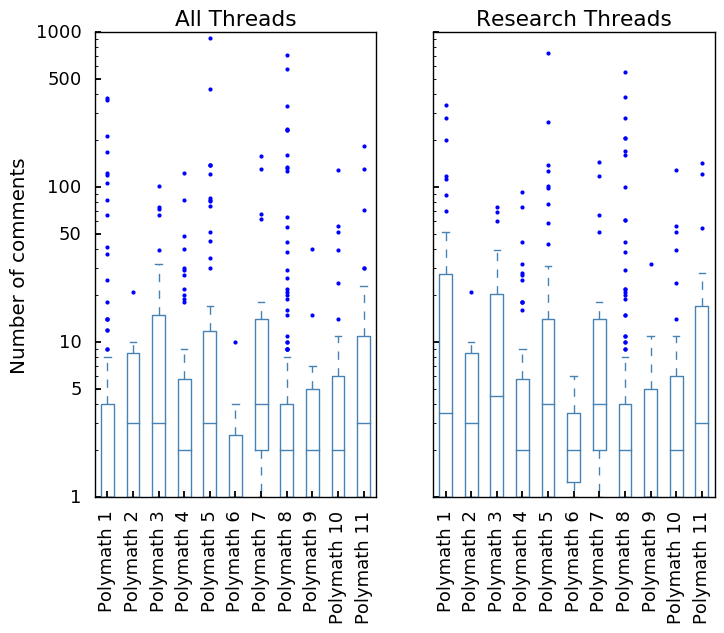

In [22]:
# create box-plot of commenting-activity
commenting_author_project_r = get_last("research threads")[0]['research threads', 'comment_counter (accumulated)']
commenting_author_project_r.index = commenting_author_project_r.index.droplevel(1)
commenting_author_project_a = get_last("all threads")[0]['all threads', 'comment_counter (accumulated)']
commenting_author_project_a.index = commenting_author_project_a.index.droplevel(1)
commenting_author_project_r = commenting_author_project_r.apply(Series).T
commenting_author_project_a = commenting_author_project_a.apply(Series).T
fig, axes = plt.subplots(1,2, figsize=(8,6))
commenting_author_project_a.apply(Series).plot(kind='box', ax=axes[0],
                                               grid=False, logy=True, sym='.',
                                               rot=90, return_type='axes',
                                               color='steelblue', 
                                               title = "All Threads")
axes[0].yaxis.set_major_formatter(ScalarFormatter())
axes[0].yaxis.set_ticks([1, 5, 10, 50, 100, 500, 1000])
axes[0].yaxis.set_ticklabels([1, 5, 10, 50, 100, 500, 1000])
axes[0].set_ylabel("Number of comments")
commenting_author_project_r.apply(Series).plot(kind='box', ax=axes[1],
                                               grid=False, logy=True, sym='.',
                                               rot=90, return_type='axes',
                                               color='steelblue',
                                               title = "Research Threads");
axes[1].yaxis.set_ticklabels([]);
for i in range(2):
    axes[i].xaxis.set_ticks_position('bottom')
    axes[i].yaxis.set_ticks_position('left')
plt.savefig("FIGS/overview_box.png")

# Polymath in Context

## “Massive collaboration”, but only because it's mathematics
+ 7 years, 11 projects (and 3 mini-projects), and 465 distinct participants.
+ Contrast: 7 Zooniverse-projects reached between 3,186 and 28,828 participants in their first 180 days (Sauermann and Franzoni 2015). 
+ Typical collaboration in mathematics is “small” (Grossman 2002).

## Online, but low-tech
+ Off-the-shelf tools like WordPress and Wiki-software.
+ Only the availability of a LaTeX-plugin was essential to the start of the project.
+ Polymath is a re-usable format, but not a re-usable tool or platform.

## More open than other forms of crowd-science
+ All contributions are visible.
+ But not everyone can be a mathematician.
+ Yet: focus on “elementary methods”.

## Less structured, but more interactive

+ No well-defined sub-tasks and division of labour.
+ No centralised aggregation.
+ No hard-coded error-correction.

+ Information doesn't only flow from nodes to central hub.
+ Aggregation and error-correction is itself distributed and interactive.

+ Harder to understand as reliable epistemic procedures.

# The Social Epistemology of Polymath

+ Polymath as a scientific community:
    + More interactive
    + Crowd-sourcing the right community
    + Crowd-sourcing the research-agenda
+ Polymath as an interactive aggregation procedure
+ Unfinished epistemic products (typology of comments in Pease and Martin 2012)

## The problem of “keeping track of the common-ground”
+ What is accepted, known failures, what is to be done
+ Discussion-threads are limited to 100 comments, and blog-posts with an extensive summary initiate a new thread
+ Common ground throughout a thread remains implicit.

### Maintaining and keeping track of the common ground is essential, but in principle very hard

# Polymath as a Scientific Community

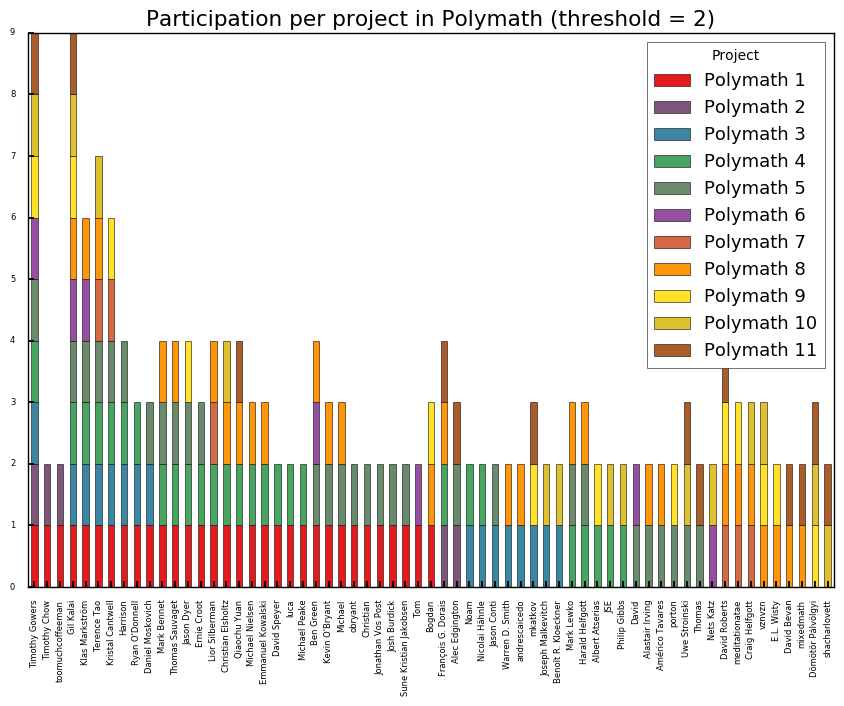

In [23]:
author_project, indices, select_2, title = project_participation_evolution(research_only=False)
plot_participation_evolution(author_project, indices, select_2, title)

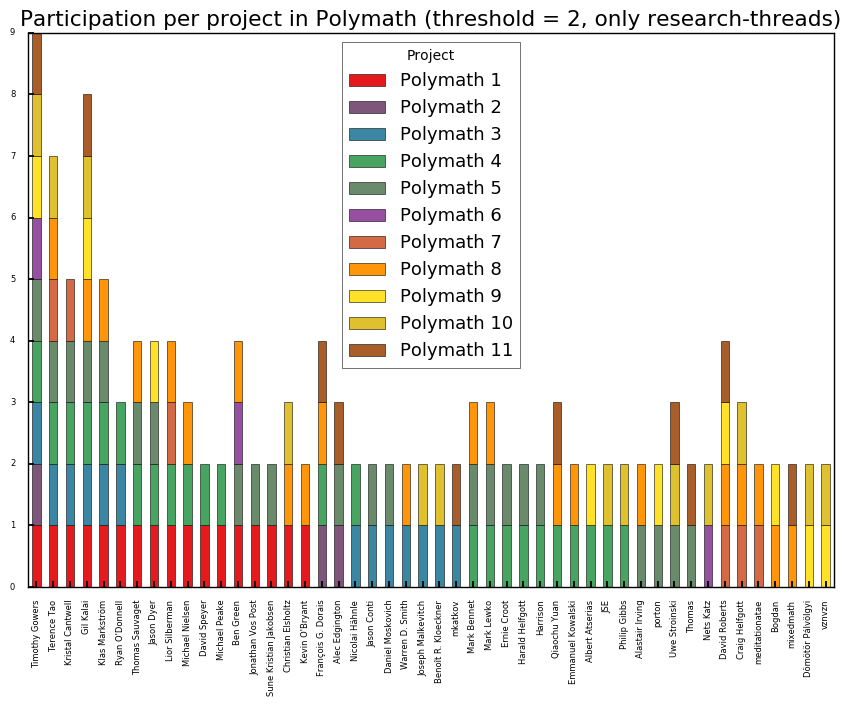

In [24]:
r_author_project, r_indices, r_select_2, title = project_participation_evolution(research_only=True)
plot_participation_evolution(r_author_project, r_indices, r_select_2, title)

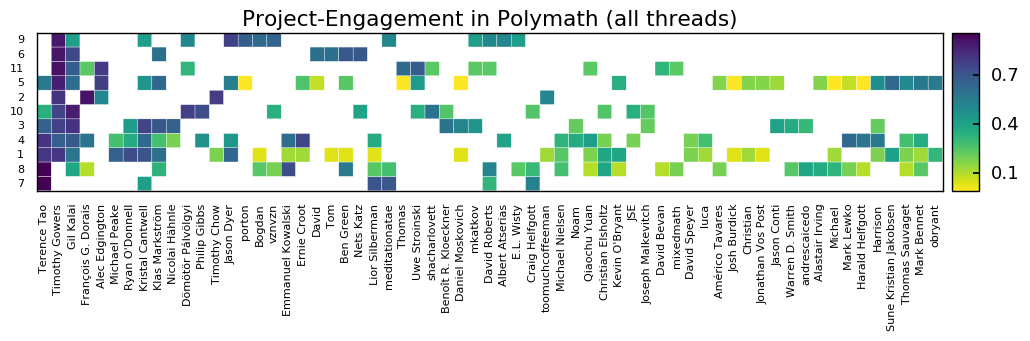

In [25]:
authors_2 = sorted([author for author, bool in select_2.items() if bool])
plot_heatmap(*general_heatmap(authors=authors_2,
                              thread_level=False,
                              binary=False,
                              scale_data=True),
             log=True)

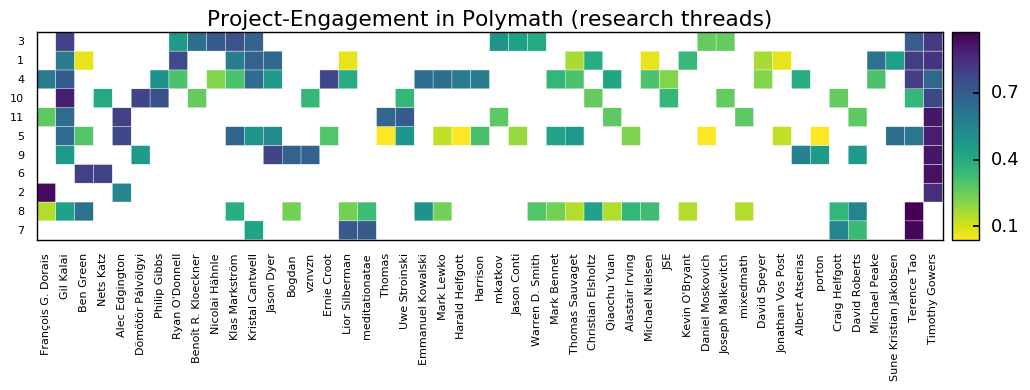

In [26]:
r_authors_2 = sorted([author for author, bool in r_select_2.items() if bool])
plot_heatmap(*general_heatmap(authors=r_authors_2, thread_level=False, binary=False, thread_type='research threads', scale_data=True),
            log=True)

+ **Global Leaders (3):** Terence Tao, Timothy Gowers, Gil Kalai
+ **Local Leaders (2):** François G. Dorais, Alex Edgington
+ **Core-participants (18/19):** Peake -> Silberman
+ **Periphery (40/39):** meditationatae -> obryant

In [27]:
# assembling data on project-participatip
author_project_bool, _, select_1, *_ = project_participation_evolution(n=1, research_only=True)
project_participation = author_project_bool.sum(axis=1)
authors_1 = sorted([author for author, bool in select_1.items() if bool])
author_counts,* _ = general_heatmap(authors=authors_1, thread_level=False, 
                binary=False)
author_counts_mod = author_counts.replace(0, np.NaN)
comment_participation = author_counts_mod.mean()
df = pd.concat([project_participation, comment_participation], axis=1).dropna()
df.columns = columns=["number of projects participated", "avg comments per project participated"]

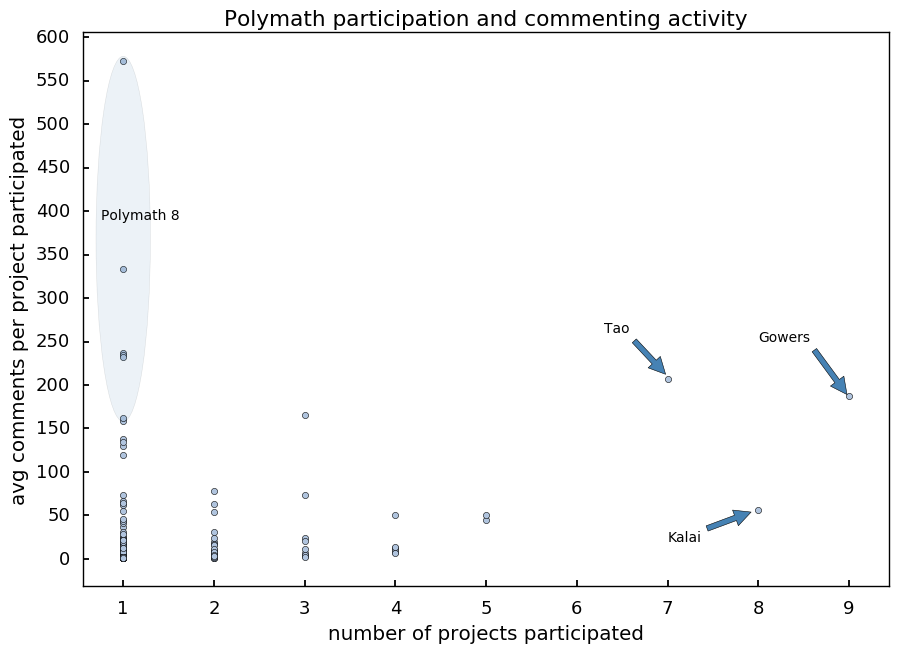

In [28]:
# plotting project-participation as scatter-plot
axes = plt.subplot()
axes.set_xticks(range(11));
axes.set_yticks(range(0, 700, 50));
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
axes.annotate('Gowers', xy=(9, 186), xytext=(8, 250),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Kalai', xy=(7.95, 55), xytext=(7, 20),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Tao', xy=(7, 210), xytext=(6.3, 260),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
e = mpl.patches.Ellipse(xy=(1,368), width=.6, height=420, angle=0)
e.set_alpha(.1)
e.set_facecolor('steelblue')
axes.add_artist(e)
axes.annotate('Polymath 8', xy=(1.2, 400), xytext=(.75, 390))
df.plot(kind='scatter', x='number of projects participated', y='avg comments per project participated',
            color= 'lightsteelblue', ax=axes, title="Polymath participation and commenting activity");



In [29]:
# assembling data on thread-participation
thread_data, *_ = general_heatmap(authors=None, binary=False, thread_level=True,
                    binary_method='average', method='ward')
thread_data = thread_data.T
thread_bool = thread_data != 0
thread_bool_sum = thread_bool.sum(axis=1)
thread_data_mean = thread_data.replace(0, np.NaN)
thread_data_mean = thread_data_mean.mean(axis=1)
df_threads = pd.concat([thread_bool_sum, thread_data_mean], axis=1)
df_threads.columns = ["number of threads participated", "avg comments per thread participated"]

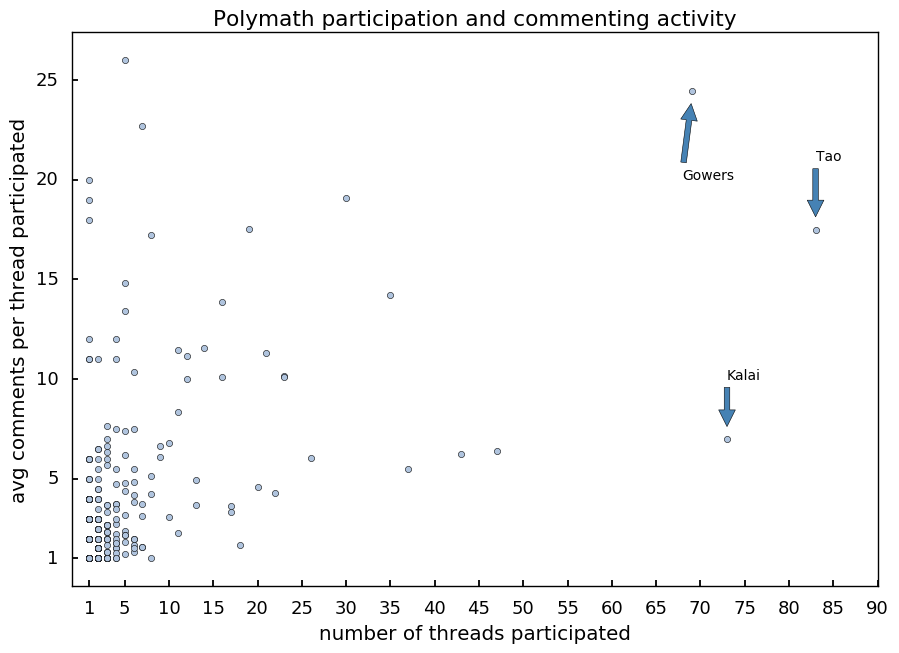

In [30]:
# plotting thread-participation as scatter-plot
axes = plt.subplot()
axes.set_xticks([1] + list(range(5,110,5)));
axes.set_yticks([1]+ list(range(5, 30, 5)));
axes.set_xlim(-1, 90);
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
axes.annotate('Gowers', xy=(69, 24), xytext=(68, 20),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Kalai', xy=(73, 7.5), xytext=(73, 10),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Tao', xy=(83, 18), xytext=(83, 21),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
df_threads.plot(kind='scatter', x='number of threads participated', y='avg comments per thread participated',
            ax=axes, color= 'lightsteelblue', title="Polymath participation and commenting activity");
#df_threads.set_index('number of threads participated', inplace=True)
#df_threads.trendline.sort_index(ascending=False).plot(ax=axes);
#plt.gca().invert_xaxis()

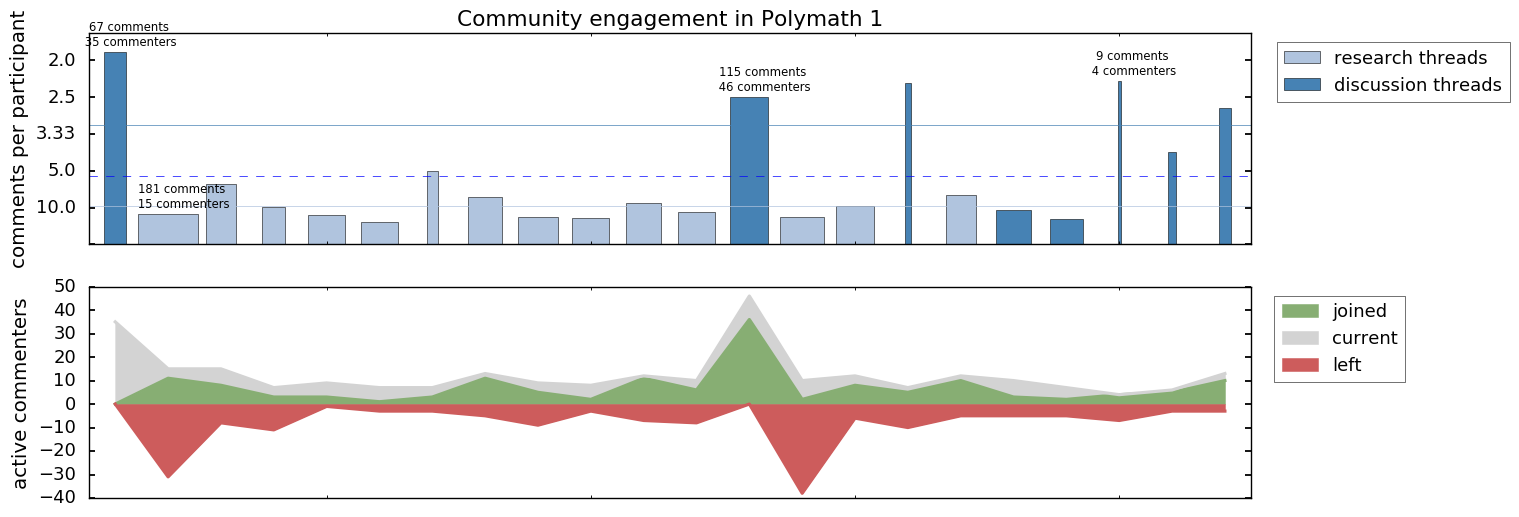

In [31]:
plot_thread_evolution("Polymath 1", compress=160, sel=[1, 2, 13, 20], sharex=True)

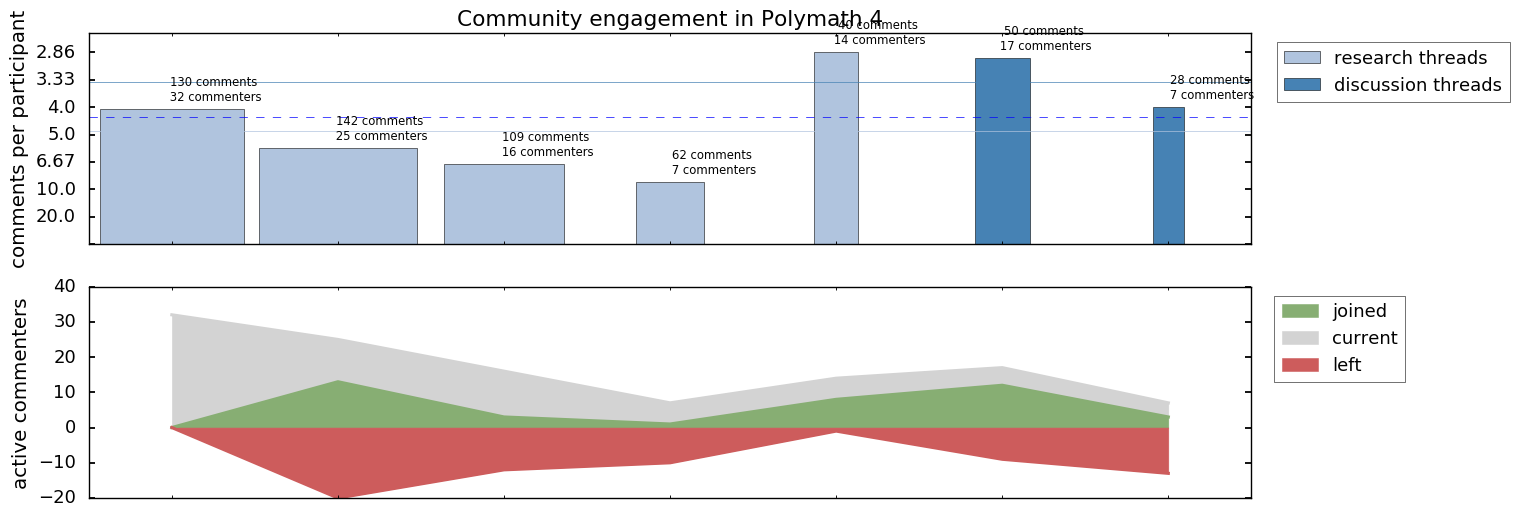

In [32]:
plot_thread_evolution("Polymath 4", compress=150, sel=range(1,8), sharex=True)

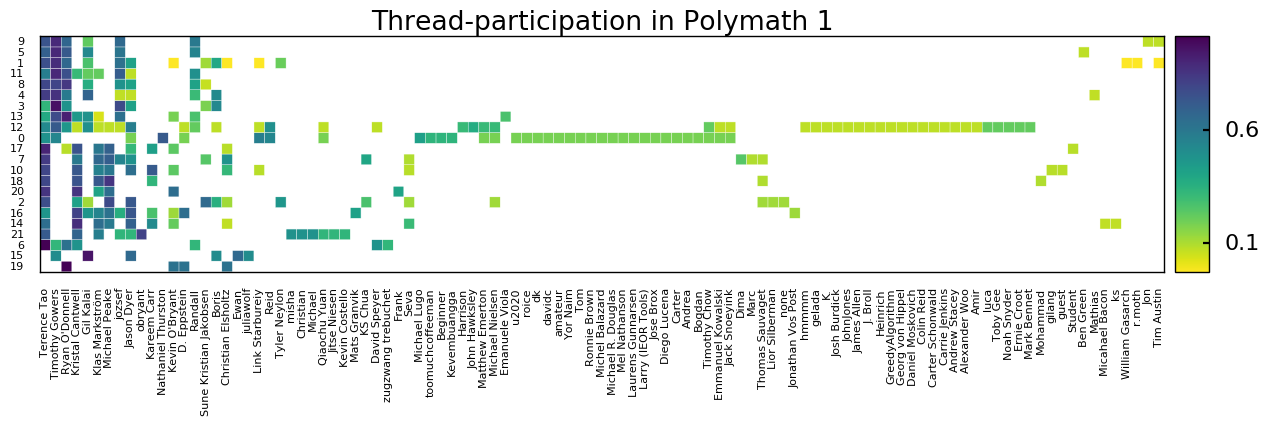

In [33]:
project_heatmap("Polymath 1", cluster_threads=True, method='average', log=True, fontsize=8)

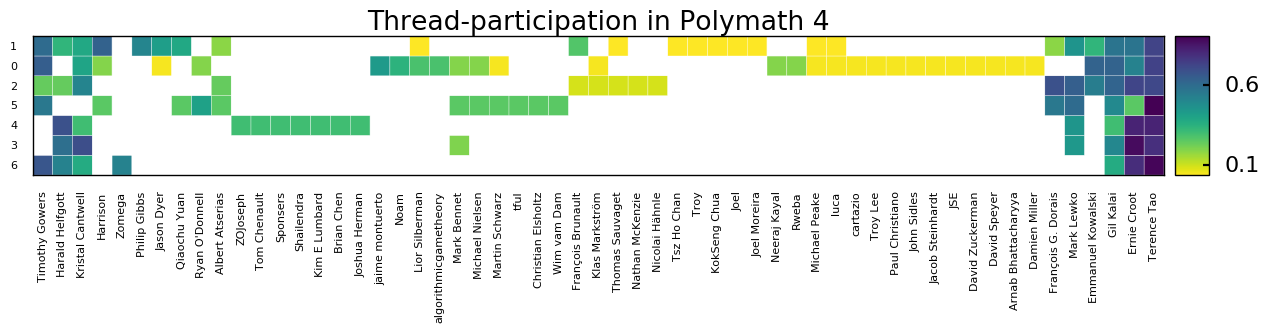

In [34]:
project_heatmap("Polymath 4", cluster_threads=True, method='average', log=True, fontsize=8)

# Social-informational patterns

### From a nested discussion to a tree of comments

#### A toy-example

+ Blog-post (L0-comment)
    + L1-comment: *timestamp: ..., author: Alice, content: ..., ...*
    + L1-comment: *timestamp: ..., author: Bob, content: ..., ...*
        + L2-comment: *timestamp: ..., author: Alice, content: ..., ...*
        + L2-comment: *timestamp: ..., author: Carol, content: ..., ...*
    + L1-comment: *timestamp: ..., author: Bob, content: ..., ...*
        + L2-sub-comment: *timestamp: ..., author: Alice, content: ..., ...*
            + L3-comment: *timestamp: ..., author: Bob, content: ..., ...*

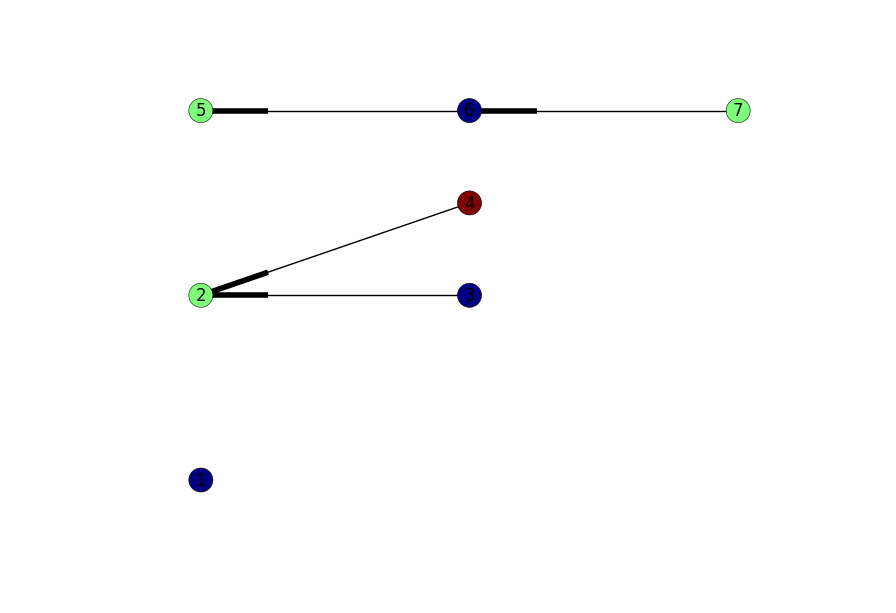

In [35]:
example_graph = nx.DiGraph()
example_graph.add_nodes_from([1,2,3,4,5,6,7])
example_graph.add_edges_from([(3,2), (4,2), (6,5), (7,6)])
matplotlib.style.use(SBSTYLE)
nx.draw_networkx(example_graph, pos={1: (0,0), 2: (0,1), 3: (1,1), 4: (1, 1.5), 5: (0, 2), 6: (1, 2), 7: (2,2)},
                 node_list=[1,2,3,4,5,6,7],
                node_color=[1, 2, 1, 3, 2, 1,2])
limits=plt.axis("off")

### To an interaction-network

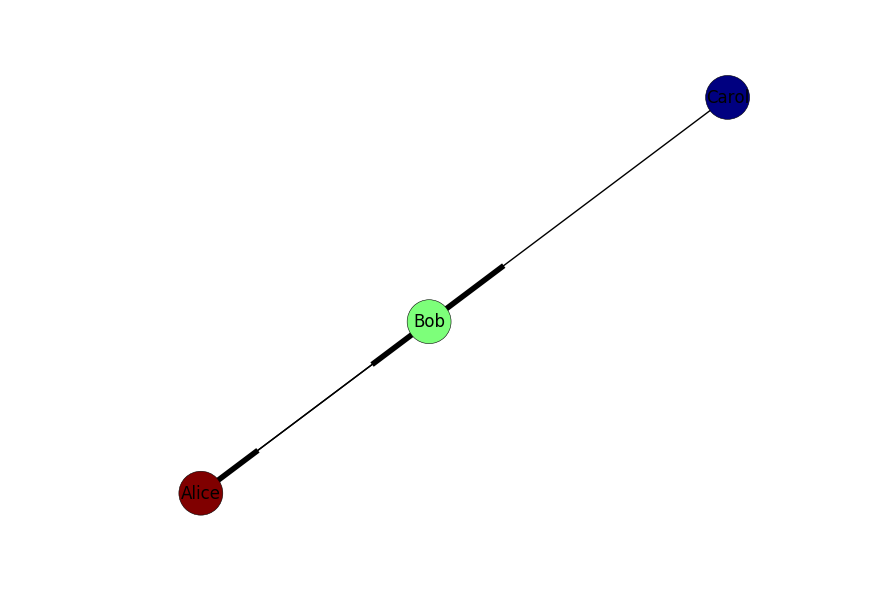

In [36]:
example_graph2 = nx.DiGraph()
example_graph2.add_nodes_from(['Alice', 'Bob', 'Carol'])
example_graph2.add_weighted_edges_from([('Alice', 'Bob', 2), ('Bob', 'Alice', 1), ('Carol', 'Bob', 1)])
matplotlib.style.use(SBSTYLE)
nx.draw_networkx(example_graph2, node_list=['Alice', 'Bob', 'Carol'], node_color=[1,3,2], node_size=1000)
limits=plt.axis("off")

### And a co-location network

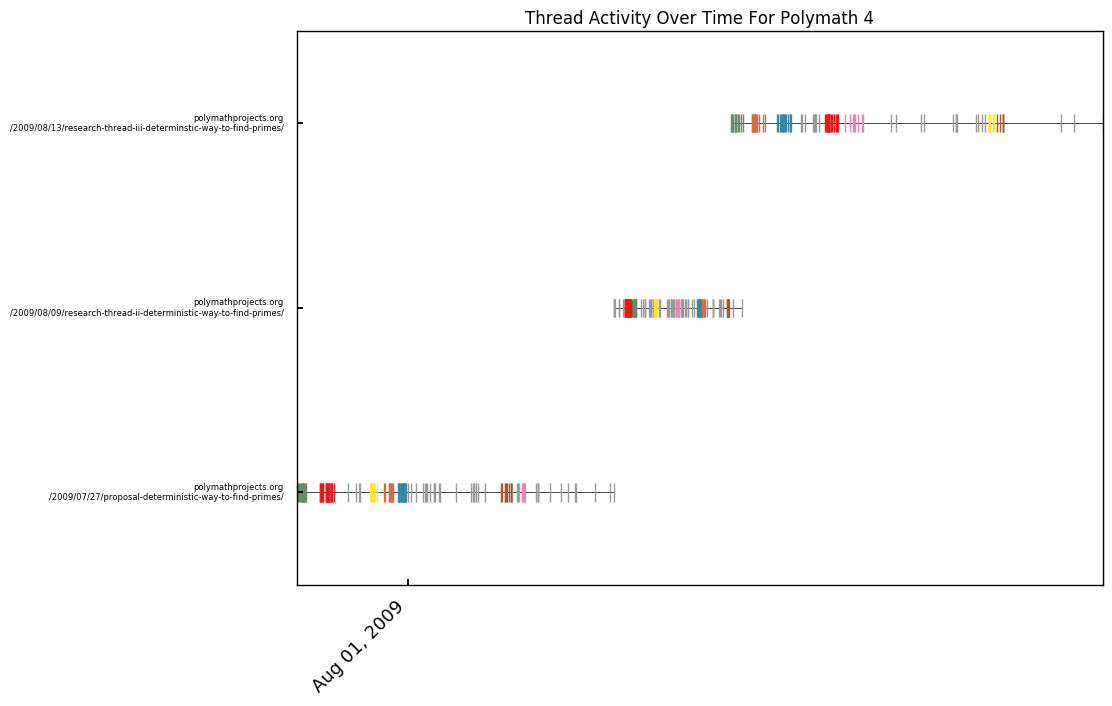

In [37]:
plot_activity_thread("Polymath 4", stage=1, thread_type="research threads")

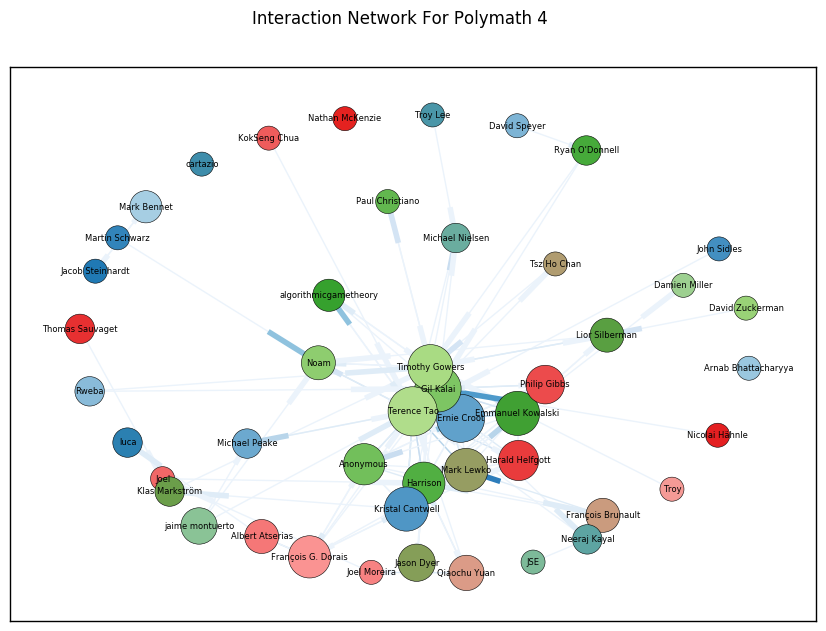

In [38]:
draw_network("Polymath 4", 'interaction', stage=2, reset=True)

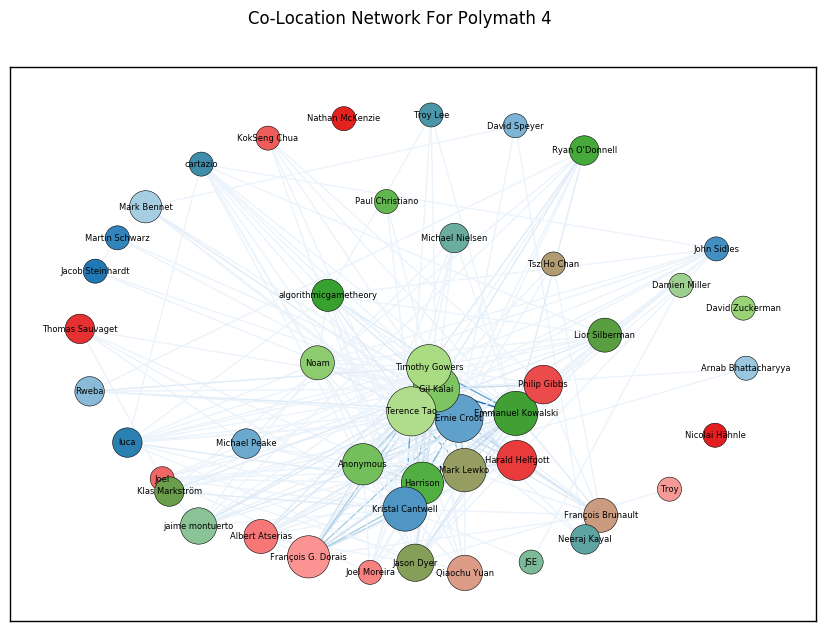

In [39]:
draw_network("Polymath 4", 'cluster', stage=2)

# Transparent informational contexts

+ Common belief requires public announcements
+ Public announcements require transparent informational contexts
+ Uncertainty about who is *present* makes informational contexts opaque

+ Asynchronous communication leads to uncertainty

## Signalling presence and reducing uncertainty
+ Episodes of intense interaction are less opaque
+ Being close to the centre of discussion is sufficient for common knowledge about who is close to the centre of discussion
+ This allows one to maintain a common ground within the sub-group close to the centre of discussion

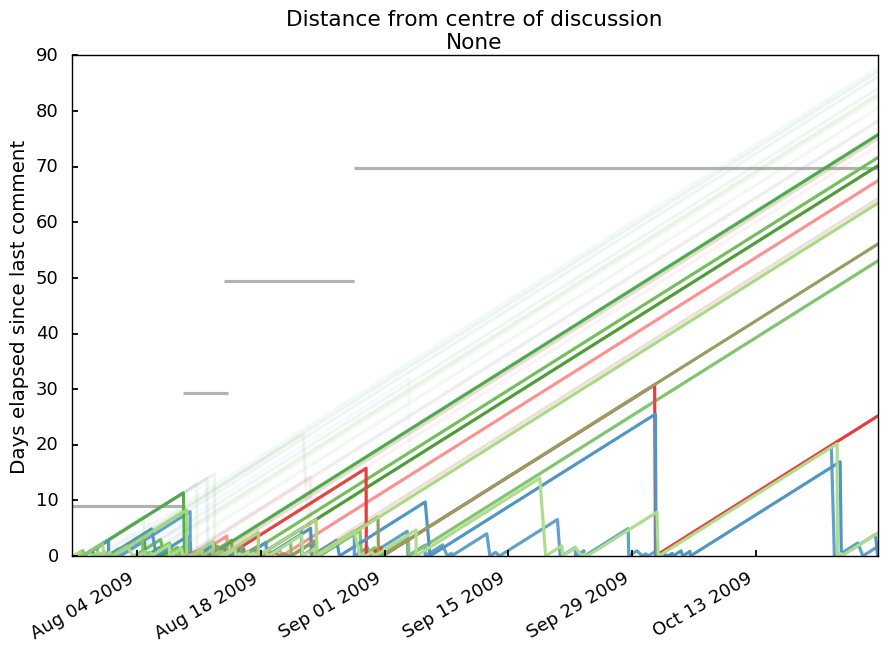

In [40]:
plot_distance_from_centre("Polymath 4", stage=2)

# The role of leading figures

+ Blog-posts as public announcements
+ Always close to the centre of discussion
+ Because presence in the centre of discussion is commonly known, the availability of leading figures is commonly known as well
+ Trust in central figures and common knowledge of their availability ensures successful aggregation, understood as further pursuing what seems promising and abandoning likely dead-ends. 

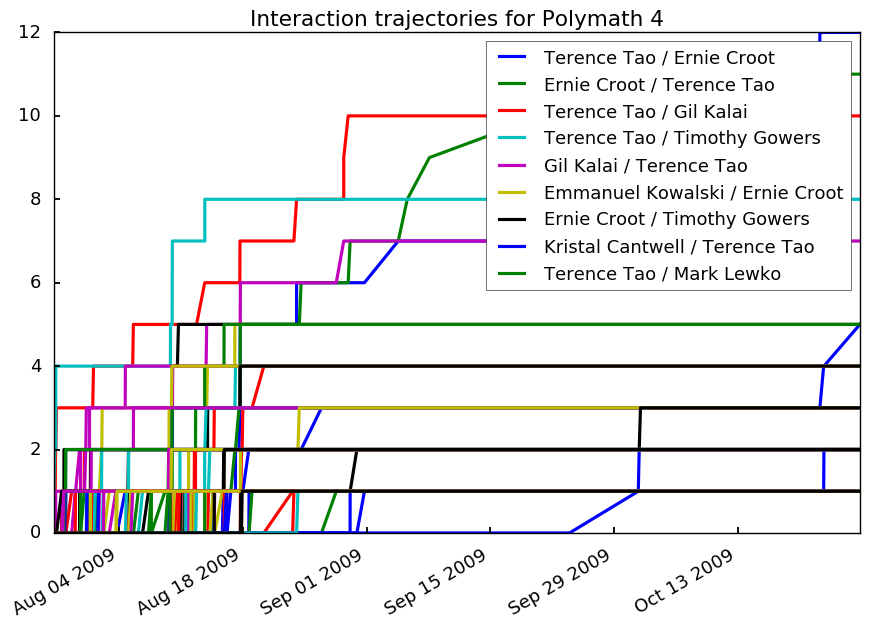

In [41]:
plot_interaction_trajectories("Polymath 4", stage=2, l_thresh=9)

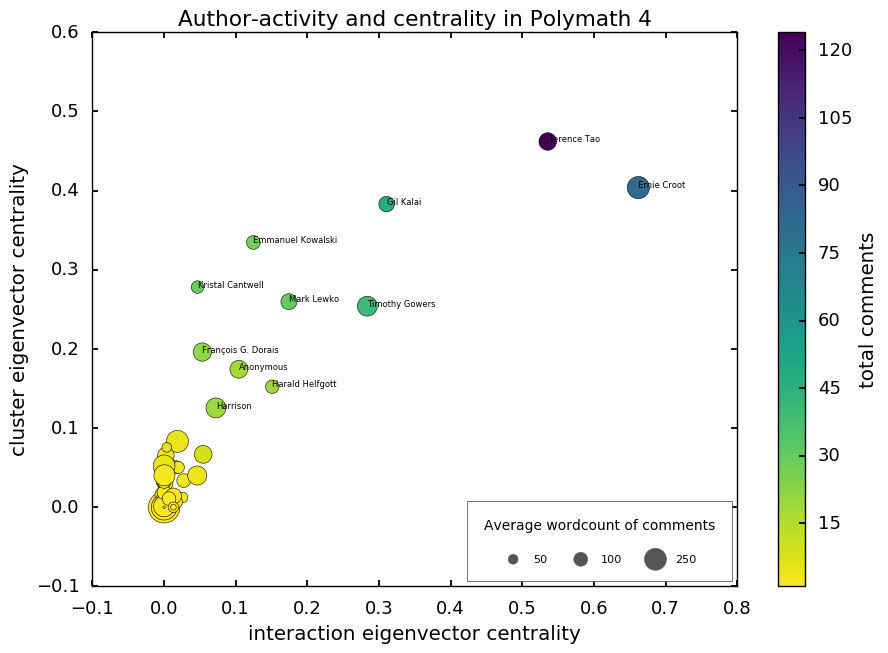

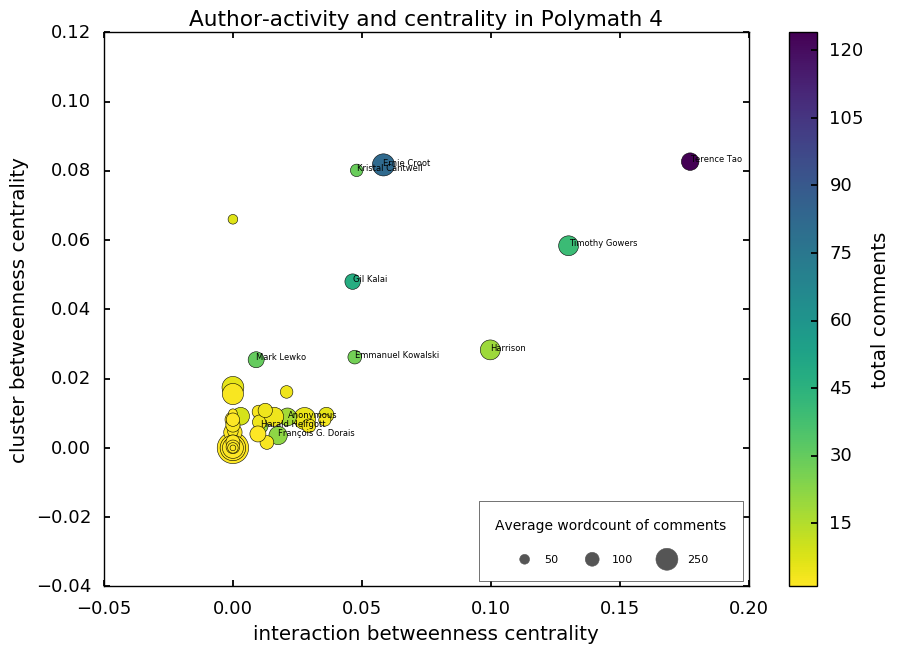

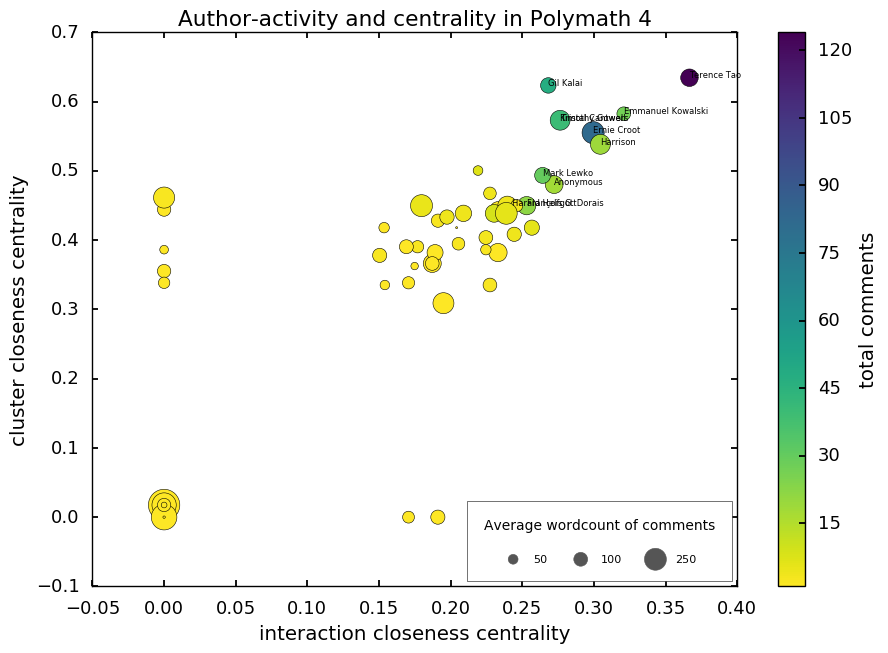

In [47]:
# comparing these two measures is rather revealing: Croot scores very high when it comes to interactions with
# other highly ranked nodes, whereas Tao, and even more so Gowers, come out high when all interactions are
# equally valued. This points to different interaction-styles (more "reactive").
# It is less clear how this should be understood in the context of the cluster-graph. (But also: shouldn't we understand
# the cluster-graph purely in terms of length-1 connections)
plot_scatter_authors("Polymath 4", stage=-1, thresh=15, measure="eigenvector centrality")
plot_scatter_authors("Polymath 4", stage=-1, thresh=15, measure="betweenness centrality")
plot_scatter_authors("Polymath 4", stage=-1, thresh=15, measure="closeness centrality")

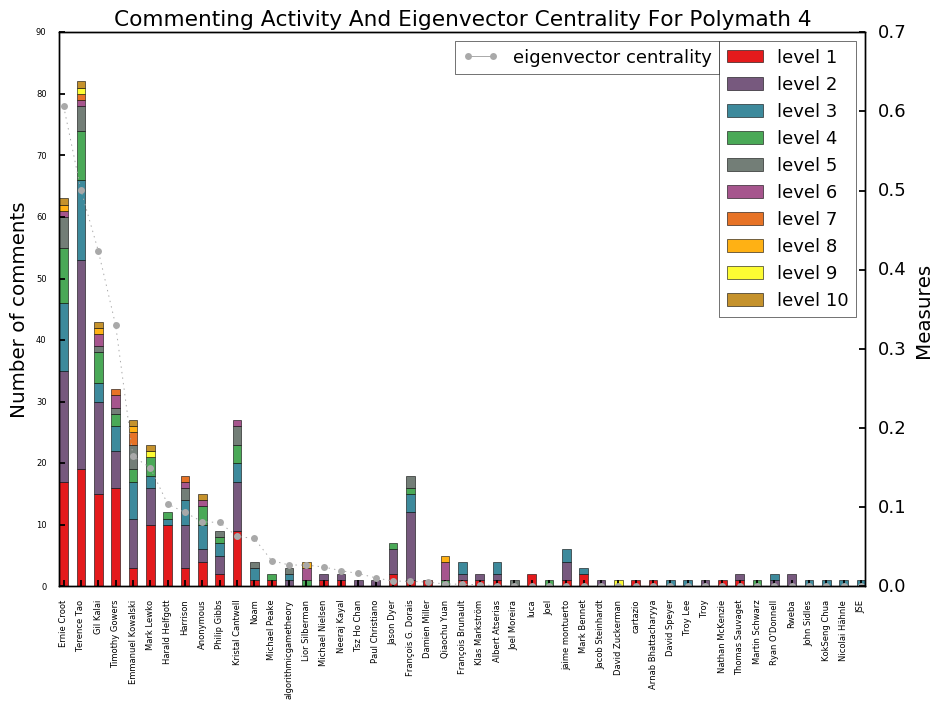

In [43]:
plot_activity_degree("Polymath 4", measures=['eigenvector centrality'], stage=2)

## Concluding remarks
+ Polymath as a community that was crowdsourced at the early stages of Polymath 1.
+ Effective collaboration through group-attitudes.
+ Active aggregation by central figures that are commonly known to be available.